# Appointment-scheduling problem

### Appointment-scheculing problem with 2 participants. Alice and Bob wants to share their calendar to search disponibilities.

In [1]:
#!pip install qiskit
#!pip install qiskit-ibm-runtime

#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import MCMT, MCMTVChain, Diagonal

# import math tools
from math import floor, ceil, sqrt, pi, log2

In [6]:
#######################################################################################################    
    
#      UTILITY
    
#######################################################################################################

# Initialize working qubits to |S> state
def Initialize_S(qc, first, last):
    """Apply a H-gate to 'qubits' in qc"""
    for q in range(last - first):
        qc.h(q + first)
    return qc

# return a list that contains the bit number
def CalculateBinary(number):
    array = []
    
    num_bits = ceil(log2(number))
    for num in range(number):
         array.append([(num >> bit) & 1 for bit in range(num_bits - 1, -1, -1)])
    return array

# return 2 dimensional array that write a bit value at the corrsponding position in array
def ExtractPosition(array):
    newArray2 = []
    for i in array:
        newArray1 = []
        q = 0
        for y in i:
            if y == 0:
                newArray1.append(q)
            q += 1
        newArray2.append(newArray1)
    return newArray2

def MesureQubits(qc, nqubits):
    for i in range(nqubits):
        qc.measure(i, i)


#######################################################################################################    
    
#      Create gates
    
#######################################################################################################

# swap all working qubits with the other participant
def SwapAll(qc, nqubits):
    for i in range(nqubits):
        qc.swap(i, i + nqubits)

# apply the X gates in the circuit on the qubits that must be conditionned to zero for Alice  
def ApplyNOT_a(pos): 
    if not pos:
        pass
    else:
        qc.x(pos)

# apply the X gates in the circuit on the qubits that must be conditionned to zero for Bob
def ApplyNOT_b(pos, nqubits): 
    temp = [i for i in pos]
    if not temp:
        pass
    else:
        for i in range(len(temp)):
            temp[i] = temp[i] + nqubits
        qc.x(temp)

# act as a a x^xi gate
def EncodePos(calendar, numPos, pos):
    qc = QuantumCircuit(1)
    if calendar[pos] == "1":
        qc.x(0)
    # We will return the function as a gate
    Encode_gate = qc.to_gate()
    Encode_gate.name = "X$^{a_%i}$" % (pos)
    return Encode_gate    

#######################################################################################################    
    
#      Create Oracles
    
#######################################################################################################    

# Create the oracle circuit for Alice      
def CreateOracleAlice(qc, numPos, calendar, nPosQubits): 
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))): # calendar must be a power of 2
        bits = CalculateBinary(numPos)
        Xpos = ExtractPosition(bits)
        targets = nqubits - 1
        MCMTPos = []
        for i in range(nqubits): 
            MCMTPos.append(i)
        i = 0
        for pos in Xpos:

            ApplyNOT_a(pos)
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits]) 
            qc.append(MCMT("x", targets, 1), MCMTPos)               # Apply multi-Toffoli gate
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits]) 
            ApplyNOT_a(pos)
            qc.barrier()
            i += 1
    else:
        raise Exception("the calendar must be a power of 2")

# Create the oracle circuit for Bob
def CreateOracleBob(qc, numPos, calendar, nPosQubits): 
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))): # calendar must be a power of 2
        nqubits = nPosQubits + 2
        bits = CalculateBinary(numPos)
        Xpos = ExtractPosition(bits)  
        targets = nqubits - 1
        MCMTPos = []
        for i in range(nqubits):
            MCMTPos.append(nqubits + i)
        i = 0
        for pos in Xpos:
            ApplyNOT_b(pos, nqubits)
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits + nqubits]) 
            qc.append(MCMT("z", targets, 1), MCMTPos)                          # Apply multi-controlled-z gate
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits + nqubits])
            ApplyNOT_b(pos, nqubits)
            qc.barrier()
            i += 1 
    else:
        raise Exception("the calendar must be a power of 2")

In [21]:
#######################################################################################################    
    
#      Data
    
#######################################################################################################

calendar_a = "10110011"
calendar_b = "11011100"
nqubits = int(log2(len(calendar_a))) + 2  # total qubit for a participant
nPosQubits = int(log2(len(calendar_a)))   # number of qubits in superposition
numPos = len(calendar_a)                  # number of positions in the calendar

#######################################################################################################    
    
#      Create cuircuits
    
#######################################################################################################

qc_a = QuantumRegister(nqubits, name = "Alice")
qc_b = QuantumRegister(nqubits, name = "Bob")
cr = ClassicalRegister(nqubits, name = "available")
qc = QuantumCircuit(qc_a, qc_b, cr)

Initialize_S(qc, 0, nPosQubits) # Alice |s> state


#######################################################################################################    
    
#      Oracle loop
    
#######################################################################################################

# iter = floor((ceil(sqrt(2**nPosQubits)) - 1)/nbSolutions) # if you know the number of solutions
iter = 1 # If we don't know the number of solutions
print("iter = ", iter)

# iterate sqrt(N)
for i in range(iter):
    # oracle Alice
    CreateOracleAlice(qc, numPos, calendar_a, nPosQubits)

    # swap with Bob
    SwapAll(qc, nqubits)
    qc.barrier()

    # oracle Bob
    CreateOracleBob(qc, numPos, calendar_b, nPosQubits)

    # swap with Alice
    SwapAll(qc, nqubits)
    qc.barrier()

    # oracle Alice
    CreateOracleAlice(qc, numPos, calendar_a, nPosQubits)

    #diffuser
    nqubits = 4
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)

#################################################################################################################  
    
    
# measurement
MesureQubits(qc, nPosQubits)
print("nPosQubits = ", nPosQubits)

# qc.draw("mpl")

iter =  1
nPosQubits =  3


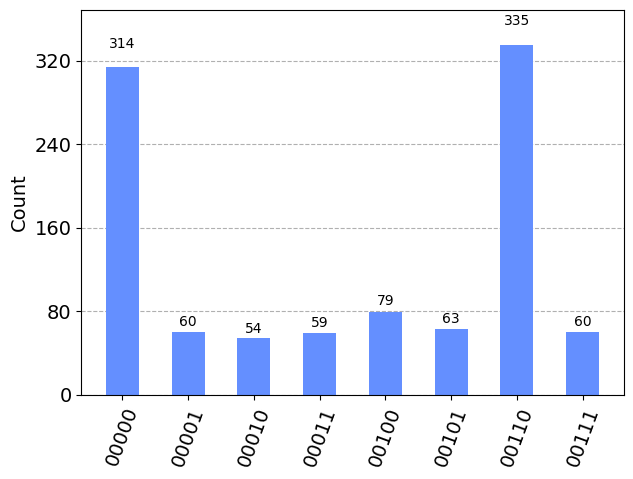

In [22]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
job = qasm_simulator.run(transpiled_qc)
plot_histogram(job.result().get_counts())

In [5]:
# Simulate state vectors
sv_sim = Aer.get_backend('statevector_simulator')
transpiled_qc = transpile(qc, sv_sim)
result = sv_sim.run(transpiled_qc).result()
statevec = result.get_statevector()

simplestatevec = []
y = 0
for i in statevec:
        simplestatevec.append(statevec[y])
        y += 1
    
# print(simplestatevec)
array_to_latex(statevec,  prefix="|\\psi\\rangle =",max_size=30)

/tmp/ipykernel_4515/3387634294.py:9: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i in statevec:


<IPython.core.display.Latex object>